In [1]:
import os
from skimage import io
from skimage.io import imread, imshow
from skimage.transform import resize
import numpy as np
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import random
from tqdm import tqdm

import tensorflow as tf
import keras

from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils import class_weight

# Loading data

In [2]:
#reading train data and generating labels
train_filepath = 'C-NMC_Leukemia/training_data/'
trainpath_array =[]
Y_train = []
all_cells=0
hem_cells=0
for i in ('/all/', '/hem/'):
    for j in range(3):
        dir_path = train_filepath+'fold_'+str(j)+str(i)
        for k in os.listdir(dir_path):
            path= os.path.join(dir_path,k)
            trainpath_array.append(path)
            if i=='/all/':
                Y_train.append(1) #asign 1 for all cells
                all_cells=all_cells+1
            else:
                Y_train.append(0) #asign 0 for hem cells
                hem_cells=hem_cells+1


In [3]:
print('Total number of cancer cells in the train dataset is',all_cells)
print('Total number of normal cells in the train dataset is',hem_cells)

Total number of cancer cells in the train dataset is 7272
Total number of normal cells in the train dataset is 3389


In [4]:
# Compute class weights
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(Y_train), y=Y_train)
class_weights_dict = dict(enumerate(class_weights))
print("Class weights:", class_weights_dict)

Class weights: {0: 1.5728828562997934, 1: 0.7330170517051705}


In [5]:
#reading test data 
val_df = pd.read_csv('C-NMC_Leukemia/validation_data/C-NMC_test_prelim_phase_data_labels.csv')
val_filename =val_df['new_names']
Y_test =val_df['labels']

test_filepath = 'C-NMC_Leukemia/testing_data/C-NMC_test_final_phase_data/'
testpath_array =[]

for i in val_filename:
    path = os.path.join(test_filepath,i)
    testpath_array.append(path)

print('Total number of cells in the test dataset is',len(testpath_array))

Total number of cells in the test dataset is 1867


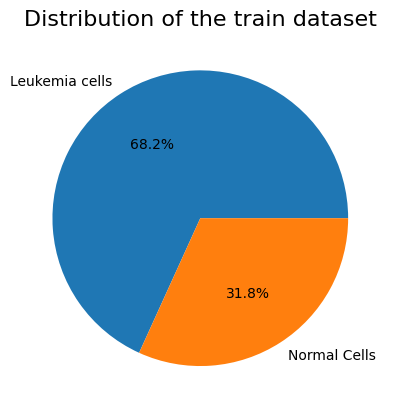

In [6]:
#Display Distribution of the train dataset
plt.pie([all_cells,hem_cells], labels=['Leukemia cells', 'Normal Cells'], autopct='%1.1f%%')
plt.title('Distribution of the train dataset', fontsize=16)
plt.show()

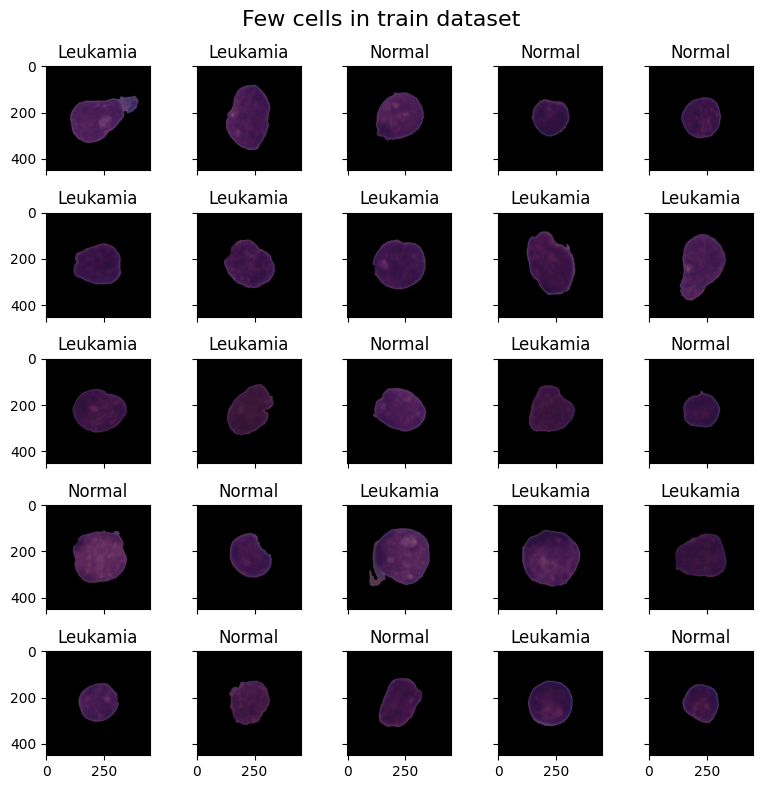

In [7]:
#display random 25 cells in the train dataset
fig, axes = plt.subplots(nrows=5, ncols=5, sharex =True, sharey=True, figsize =(8,8))
ax =axes.ravel()
for i in range(0,25):
    ran = random.randint(0,len(trainpath_array))
    img= io.imread(trainpath_array[ran])
    ax[i].imshow(img)
    if Y_train[ran]==1:
        ax[i].set_title('Leukamia')
    else:
        ax[i].set_title('Normal')
fig.suptitle('Few cells in train dataset', fontsize=16)
plt.tight_layout()
plt.show()

In [8]:
#explore the size of train images
train_img =io.imread(trainpath_array[0])

print('Shape of a train cell image', train_img.shape)

Shape of a train cell image (450, 450, 3)


In [9]:
def resize_img(path_array):
    img_width= 224
    img_height= 224
    img_channels= 3

    img_array= np.zeros((len(path_array), img_height, img_width, img_channels), dtype=np.uint8)
    print('Loading resized cell images')
    for i in tqdm(range(len(path_array))):
        img= io.imread(path_array[i])
        #resize the image
        img= resize(img, (img_height, img_width), mode ='constant', preserve_range=True)
        img_array[i]= img
    return img_array

In [10]:
#resized train data
X_train = resize_img(trainpath_array)

Loading resized cell images


100%|████████████████████████████████████████████████████████████████████████████████| 10661/10661 [04:46<00:00, 37.27it/s]


In [11]:
#convert Y_train to an array 
Y_train= np.array(Y_train)
#shape of X_train and Y_train
X_train.shape, Y_train.shape

((10661, 224, 224, 3), (10661,))

In [12]:
#explore the size of test images
test_img =io.imread(testpath_array[0])

print('Shape of a test cell image', test_img.shape)

Shape of a test cell image (600, 600, 3)


In [13]:
#resized test data
X_test = resize_img(testpath_array)

Loading resized cell images


100%|██████████████████████████████████████████████████████████████████████████████████| 1867/1867 [01:04<00:00, 28.89it/s]


In [14]:
#convert Y_test to an array 
Y_test= np.array(Y_test)
#shape of X_test and Y_test
X_test.shape, Y_test.shape

((1867, 224, 224, 3), (1867,))

In [15]:
#resized image shape
img_width= 224
img_height= 224
img_channels= 3


In [16]:
all_=0
hem_=0
for i in Y_test:
    if i==1:
        all_=all_+1
    else:
        hem_= hem_+1
print ("Total all in test data:",all_, "Total hem in test data:", hem_)


Total all in test data: 1219 Total hem in test data: 648


In [27]:
# Input layer
# Normalize input data using ImageDataGenerator
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,        # Normalize pixel values to [0, 1]
)

test_datagen = ImageDataGenerator(
    rescale=1.0/255.0         # Only normalization for validation data
)

# Use flow() to load data from arrays
train_generator = train_datagen.flow(X_train, Y_train, batch_size=16, shuffle=True)
test_generator = test_datagen.flow(X_test, Y_test, batch_size=16, shuffle=False)

# Model architecture using EfficientNetB0
input_shape = (img_width, img_height, img_channels)
inp = tf.keras.Input(shape=input_shape)

# Load EfficientNetB0 base model
base_model = EfficientNetB0(
    include_top=False,
    weights='imagenet',
    input_tensor=inp,
    pooling='max'
)


# Add custom layers
x = layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01), activity_regularizer= regularizers.l1(0.006),
                bias_regularizer= regularizers.l1(0.006))(base_model.output)
x = layers.BatchNormalization(axis= -1, momentum= 0.99, epsilon= 0.001)(x)
x = layers.Dropout(0.6)(x)
output = layers.Dense(1, activation='sigmoid')(x)

# Define the model
model = models.Model(inputs=inp, outputs=output)

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)    │ (None, 224, 224, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ rescaling_6 (Rescaling)       │ (None, 224, 224, 3)       │               0 │ input_layer_3[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ normalization_3               │ (None, 224, 224, 3)       │               7 │ rescaling_6[0][0]          │
│ (Normalization)               │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ rescaling_7 (Rescaling)       │ (None, 224, 224, 3)       │               0 │ normalization_3[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stem_conv_pad (ZeroPadding2D) │ (None, 225, 225, 3)       │               0 │ rescaling_7[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stem_conv (Conv2D)            │ (None, 112, 112, 32)      │             864 │ stem_conv_pad[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stem_bn (BatchNormalization)  │ (None, 112, 112, 32)      │             128 │ stem_conv[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stem_activation (Activation)  │ (None, 112, 112, 32)      │               0 │ stem_bn[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_dwconv                │ (None, 112, 112, 32)      │             288 │ stem_activation[0][0]      │
│ (DepthwiseConv2D)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_bn                    │ (None, 112, 112, 32)      │             128 │ block1a_dwconv[0][0]       │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_activation            │ (None, 112, 112, 32)      │               0 │ block1a_bn[0][0]           │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_se_squeeze            │ (None, 32)                │               0 │ block1a_activation[0][0]   │
│ (GlobalAveragePooling2D)      │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_se_reshape (Reshape)  │ (None, 1, 1, 32)          │               0 │ block1a_se_squeeze[0][0]   │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_se_reduce (Conv2D)    │ (None, 1, 1, 8)           │             264 │ block1a_se_reshape[0][0]   │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1a_se_expand (Conv2D)    │ (None, 1, 1, 32)          │             28

 Total params: 4,214,180 (16.08 MB)

 Trainable params: 4,171,901 (15.91 MB)

 Non-trainable params: 42,279 (165.16 KB)

In [28]:
#Fit the model
checkpointer = tf.keras.callbacks.ModelCheckpoint('model_for_leukemia.keras', verbose=1, monitor='val_loss', save_best_only=True)

callbacks = [
        tf.keras.callbacks.EarlyStopping(patience=5, monitor='val_accuracy', restore_best_weights=True),
        tf.keras.callbacks.TensorBoard(log_dir='logs'), 
        tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=0.00001),
        checkpointer]

history = model.fit(train_generator, validation_data=test_generator, verbose = 1, epochs = 25,
                         shuffle = False, callbacks = callbacks,class_weight=class_weights_dict)

Epoch 1/25


C:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


667/667 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5014 - loss: 2.6483
Epoch 1: val_loss improved from inf to 0.98301, saving model to model_for_leukemia.keras
667/667 ━━━━━━━━━━━━━━━━━━━━ 1008s 1s/step - accuracy: 0.5014 - loss: 2.6470 - val_accuracy: 0.6020 - val_loss: 0.9830 - learning_rate: 0.0010
Epoch 2/25
667/667 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5936 - loss: 0.8910
Epoch 2: val_loss improved from 0.98301 to 0.74055, saving model to model_for_leukemia.keras
667/667 ━━━━━━━━━━━━━━━━━━━━ 705s 1s/step - accuracy: 0.5935 - loss: 0.8910 - val_accuracy: 0.3471 - val_loss: 0.7406 - learning_rate: 0.0010
Epoch 3/25
667/667 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5197 - loss: 0.7490
Epoch 3: val_loss improved from 0.74055 to 0.72136, saving model to model_for_leukemia.keras
667/667 ━━━━━━━━━━━━━━━━━━━━ 697s 1s/step - accuracy: 0.5197 - loss: 0.7490 - val_accuracy: 0.6529 - val_loss: 0.7214 - learning_rate: 0.0010
Epoch 4/25
667/667 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - a

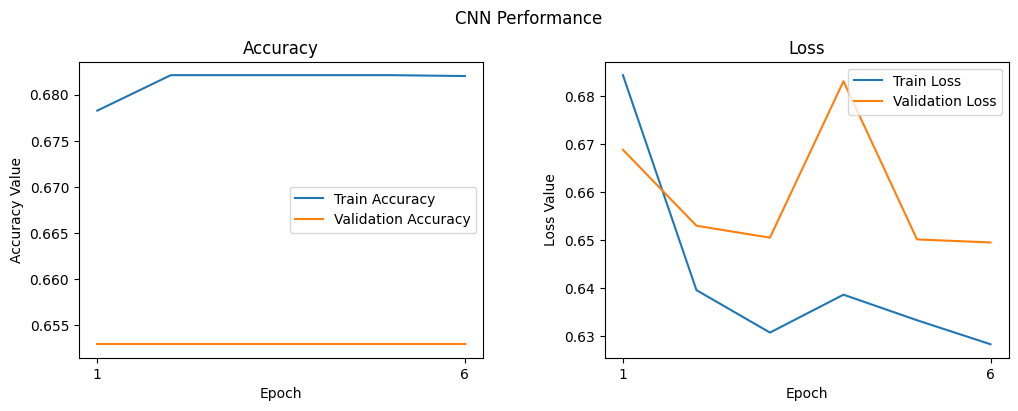

In [23]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('CNN Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

max_epoch = len(history.history['accuracy'])+1
epoch_list = list(range(1,max_epoch))
ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(1, max_epoch, 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(1, max_epoch, 5))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")